# Data prep

In [ ]:
import pandas as pd
import glob

# Define file path pattern (adjust path if needed)
files = [
   '/content/2025-03-01.csv','/content/2025-03-02.csv','/content/2025-03-03.csv','/content/2025-03-04.csv','/content/2025-03-05.csv',
   '/content/2025-03-06.csv','/content/2025-03-07.csv','/content/2025-03-08.csv','/content/2025-03-09.csv','/content/2025-03-10.csv',
   '/content/2025-03-11.csv','/content/2025-03-12.csv','/content/2025-03-13.csv','/content/2025-03-14.csv','/content/2025-03-15.csv',
   '/content/2a025-03-16.csv','/content/2025-03-17.csv','/content/2025-03-18.csv','/content/2025-03-19.csv','/content/2025-03-20.csv',
   '/content/2025-03-21.csv','/content/2025-03-22.csv','/content/2025-03-23.csv','/content/2025-03-24.csv','/content/2025-03-25_sim.csv',
   '/content/2025-03-26_sim.csv','/content/2025-03-27_sim.csv','/content/2025-03-28_sim.csv','/content/2025-03-29_sim.csv']
  # Adjust to your actual file names

# Load and concatenate all files
df_list = [pd.read_csv(file, parse_dates=['date_time']) for file in files]
df_combined = pd.concat(df_list)

# Ensure timestamps are sorted
df_combined = df_combined.sort_values(by='date_time')

# Drop duplicates if any
df_combined = df_combined.drop_duplicates()

# Check for missing values
print("Missing values per column:\n", df_combined.isnull().sum())

# Save the combined file
df_combined.to_csv("combined_train_data.csv", index=False)

print("Training data merged and saved as 'combined_train_data.csv'.")


Missing values per column:
 date_time    0
load         0
dtype: int64
Training data merged and saved as 'combined_train_data.csv'.


# ADF test

In [ ]:
import pandas as pd

# Load the combined training data
train_df = pd.read_csv('combined_train_data.csv', parse_dates=['date_time'])

# Set the 'date_time' column as the index
train_df.set_index('date_time', inplace=True)

# Display basic info
print(train_df.info())

# Display the first few rows
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2784 entries, 2025-03-01 00:00:00 to 2025-03-29 23:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    2784 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB
None
                             load
date_time                        
2025-03-01 00:00:00  11432.431510
2025-03-01 00:15:00  11842.011393
2025-03-01 00:30:00  11806.792383
2025-03-01 00:45:00  11722.334831
2025-03-01 01:00:00  11472.657487


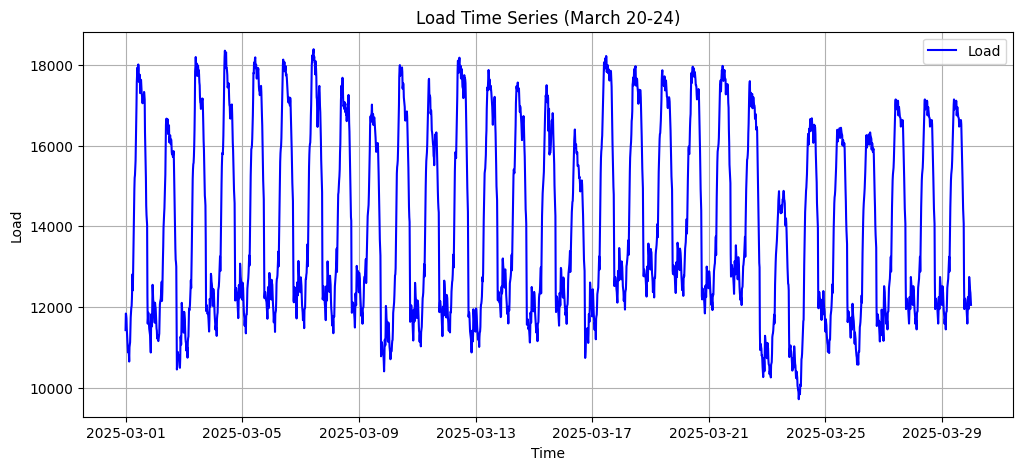

In [ ]:
import matplotlib.pyplot as plt

# Plot the original time series
plt.figure(figsize=(12, 5))
plt.plot(train_df['load'], label='Load', color='b')
plt.title('Load Time Series (March 20-24)')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Function to run ADF test
def adf_test(series):
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    # Interpretation
    if result[1] < 0.05:
        print("✅ The data is stationary (Reject H0)")
    else:
        print("❌ The data is non-stationary (Fail to reject H0)")

# Run ADF test on the original load data
adf_test(train_df['load'])


ADF Test Results:
ADF Statistic: -14.969191704706882
p-value: 1.2072519540646769e-27
Critical Values: {'1%': np.float64(-3.432725827000873), '5%': np.float64(-2.862589670460055), '10%': np.float64(-2.5673287729948187)}
✅ The data is stationary (Reject H0)


# Train test split

In [ ]:
# here /content/2025-03-25.csv is just the WMA results

In [ ]:
import pandas as pd

# Load the full dataset (March 1 to March 29)
data = pd.read_csv('combined_train_data.csv', parse_dates=['date_time'], index_col='date_time')

# Define training and testing splits
train = data.loc[:'2025-03-24 23:45:00']  # Training set: March 1 to March 24
test = data.loc['2025-03-25 00:00:00':'2025-03-29 23:45:00']  # Test set: March 25 to March 29

# Save the split datasets
train.to_csv('train_data.csv')
test.to_csv('test_data.csv')

print(f"Training data: {train.shape}")
print(f"Testing data: {test.shape}")

Training data: (2304, 1)
Testing data: (480, 1)


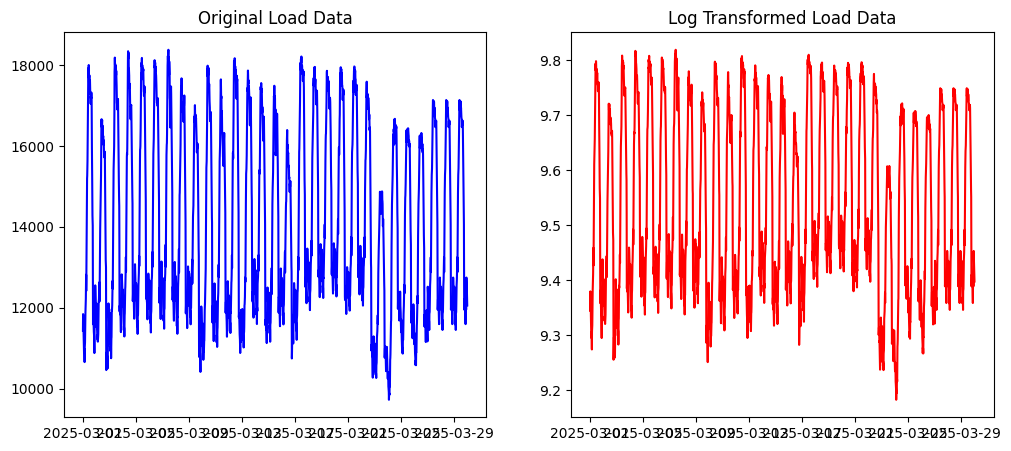

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
train_data = pd.read_csv('combined_train_data.csv', parse_dates=['date_time'], index_col='date_time')

# Plot original vs. log-transformed data
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_data['load'], color='blue')
plt.title("Original Load Data")

plt.subplot(1,2,2)
plt.plot(np.log(train_data['load']), color='red')
plt.title("Log Transformed Load Data")

plt.show()


# ACF PACF test

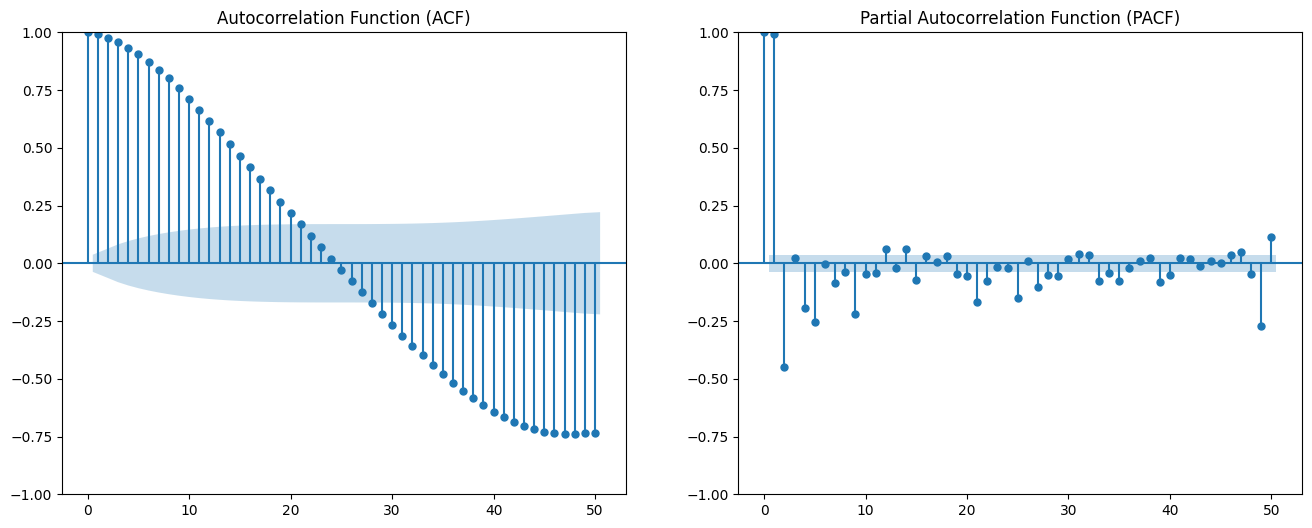

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF Plot
sm.graphics.tsa.plot_acf(train_data['load'], lags=50, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot
sm.graphics.tsa.plot_pacf(train_data['load'], lags=50, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


# Grid search for (p d q)(P D Q s)

In [ ]:
# conventionally p = d = q = range(0, 2)  P = D = Q = range(0, 2) this should
# be the code but i have changed here below because the ADF test gave
# data to be stationary so i explicitly mentioned d & D = 0
# so before running grid search make sure of this

In [ ]:
import itertools
import numpy as np
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# Define the range of (p, d, q)
p = q = range(0, 2)  # Reduce max to 1 instead of 2
P = Q = range(0, 2)
d = [0]  # Set differencing to 0 (since data is stationary)
D = [0]  # Set seasonal differencing to 0
pdq = list(itertools.product(p, d, q))
s = 96  # 15-minute interval daily seasonality

# Define seasonal order (P, D, Q, s) where s = 96 (daily seasonality in 15-minute data)
seasonal_pdq = [(x[0], x[1], x[2], 96) for x in itertools.product(p, d, q)]

# Store best parameters
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None

print("Running Grid Search for best SARIMA parameters...")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit SARIMA model
            model = sm.tsa.statespace.SARIMAX(train_data['load'],
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            results = model.fit()

            print(f"SARIMA {param} x {param_seasonal} - AIC: {results.aic}")

            # Check if AIC is better
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal

        except Exception as e:
            print(f"Error: {e}")

print(f"\nBest Model: SARIMA {best_pdq} x {best_seasonal_pdq} - AIC: {best_aic}")


Running Grid Search for best SARIMA parameters...
SARIMA (0, 0, 0) x (0, 0, 0, 96) - AIC: 61141.21267049966
SARIMA (0, 0, 0) x (0, 0, 1, 96) - AIC: 57189.516718451305
SARIMA (0, 0, 0) x (1, 0, 0, 96) - AIC: 43507.538841656395
SARIMA (0, 0, 0) x (1, 0, 1, 96) - AIC: 43177.82205220499
SARIMA (0, 0, 1) x (0, 0, 0, 96) - AIC: 59065.47878937455
SARIMA (0, 0, 1) x (0, 0, 1, 96) - AIC: 56552.98456825077
SARIMA (0, 0, 1) x (1, 0, 0, 96) - AIC: 40398.92481635889
SARIMA (0, 0, 1) x (1, 0, 1, 96) - AIC: 40045.88040458338
SARIMA (1, 0, 0) x (0, 0, 0, 96) - AIC: 39600.40618084546
SARIMA (1, 0, 0) x (0, 0, 1, 96) - AIC: 36220.605702551235
SARIMA (1, 0, 0) x (1, 0, 0, 96) - AIC: 33417.631999771744
SARIMA (1, 0, 0) x (1, 0, 1, 96) - AIC: 32339.048223132366
SARIMA (1, 0, 1) x (0, 0, 0, 96) - AIC: 38951.316821139815
SARIMA (1, 0, 1) x (0, 0, 1, 96) - AIC: 35844.17740980959
SARIMA (1, 0, 1) x (1, 0, 0, 96) - AIC: 33419.56646862143
SARIMA (1, 0, 1) x (1, 0, 1, 96) - AIC: 32327.75459568774

Best Model: SAR

In [ ]:
#AutoARIMA for pdq selection








##########
# dont run this now we see this in home
##########










import pmdarima as pm

# Load your training data (make sure it's a pandas Series)
train_series = train_data['load']

# Fit Auto ARIMA model
auto_arima_model = pm.auto_arima(
    train_series,
    seasonal=True,        # Enable seasonality
    m=96,                 # Seasonality period (96 for 15-min interval with daily pattern)
    stepwise=True,        # Enable stepwise search for faster execution
    trace=True,           # Print model selection progress
    suppress_warnings=True,
    max_p=2, max_q=2,     # Reduce search space for faster execution
    max_P=2, max_Q=2,
    max_d=2, max_D=2
)

# Print the best found order
print("Best SARIMA order:", auto_arima_model.order)
print("Best Seasonal order:", auto_arima_model.seasonal_order)


# Model defination, Prediction and saving

In [ ]:
# Import necessary libraries
import statsmodels.api as sm
import pandas as pd

# Train the final SARIMA model
best_model = sm.tsa.statespace.SARIMAX(
    train_data,
    order=(1, 0, 1),               # Best pdq
    seasonal_order=(1, 0, 1, 96),   # Best seasonal pdq
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = best_model.fit()

# Print model summary
print(sarima_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 2784
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 96)   Log Likelihood              -16158.877
Date:                            Tue, 15 Apr 2025   AIC                          32327.755
Time:                                    17:47:43   BIC                          32357.234
Sample:                                03-01-2025   HQIC                         32338.418
                                     - 03-29-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9943      0.002    455.912      0.000       0.990       0.999
ma.L1         -0.0256      0.011   

In [ ]:
import pandas as pd

# Load the CSV files properly
test_data = pd.read_csv('/content/test_data.csv', parse_dates=['date_time'], index_col='date_time')
train_data = pd.read_csv('/content/train_data.csv', parse_dates=['date_time'], index_col='date_time')

# Generate Predictions for March 25th (Test Data)
predictions = sarima_results.predict(start=len(train_data),
                                     end=len(train_data) + len(test_data) - 1,
                                     dynamic=False)

# Ensure test_data is a DataFrame and use its index for predictions
predictions_df = pd.DataFrame({'date_time': test_data.index, 'load': predictions.values})

# Show sample predictions
print(predictions_df.head())


            date_time          load
0 2025-03-25 00:00:00  11545.635783
1 2025-03-25 00:15:00  11773.732872
2 2025-03-25 00:30:00  11643.385180
3 2025-03-25 00:45:00  11545.310756
4 2025-03-25 01:00:00  11331.687238


In [ ]:
# Save predictions to CSV
predictions_df.to_csv("sarima_predictions.csv", index=False)

print("Predictions saved as 'sarima_predictions.csv'")

Predictions saved as 'sarima_predictions.csv'


# spilting the predictions date_Wise


In [ ]:
import pandas as pd
import os

# Load predictions
pred_df = pd.read_csv('sarima_predictions.csv', parse_dates=['date_time'])

# Ensure the predictions folder exists
os.makedirs('/content/predictions', exist_ok=True)

# Loop over dates from 25 to 29 March
for day in range(25, 30):
    date_str = f'2025-03-{day:02d}'
    daily_df = pred_df[pred_df['date_time'].dt.date == pd.to_datetime(date_str).date()]

    # Save to individual CSV
    output_path = f'/content/predictions/{date_str}_predicted.csv'
    daily_df.to_csv(output_path, index=False)

print("✅ Predictions split and saved by date in '/content/predictions/' folder.")


✅ Predictions split and saved by date in '/content/predictions/' folder.


# Metrics and Visualization

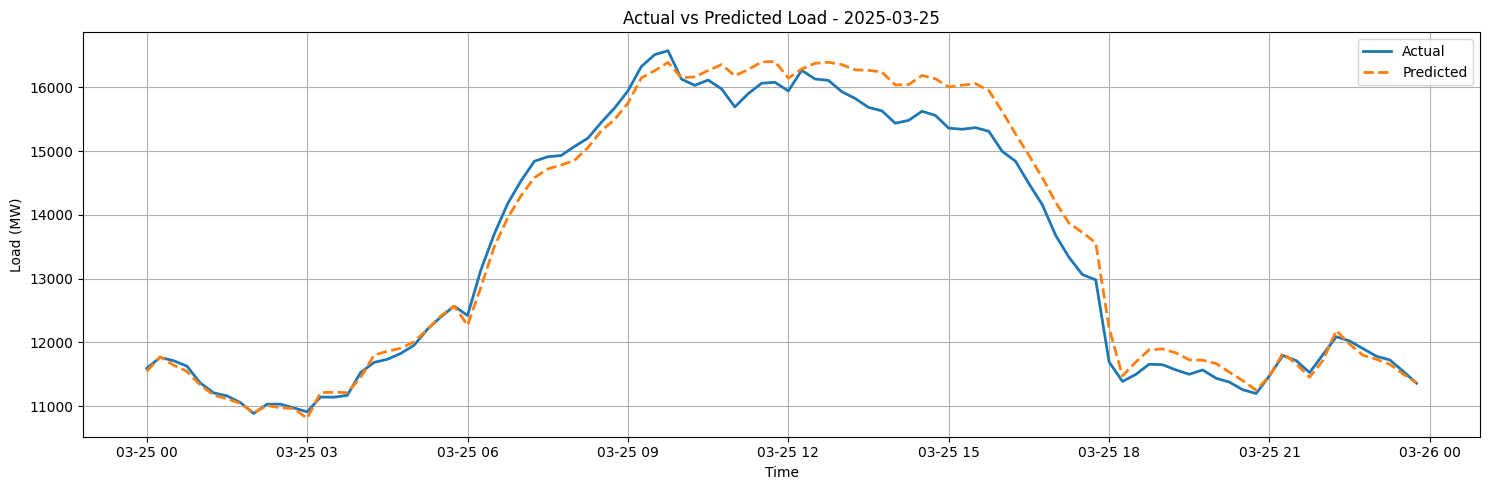

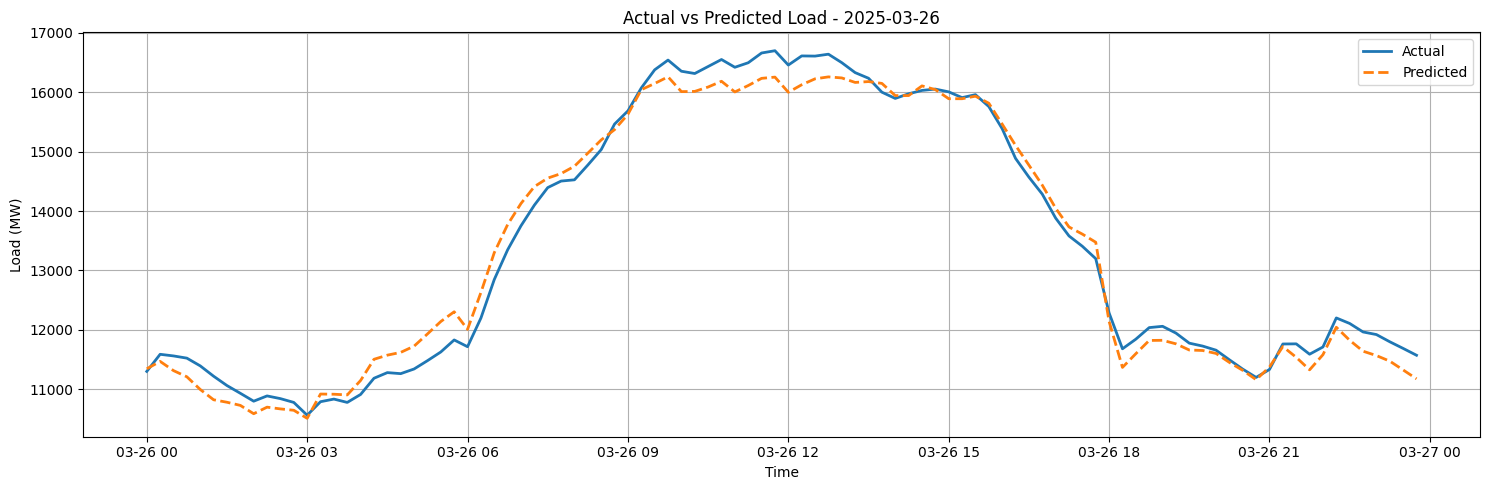

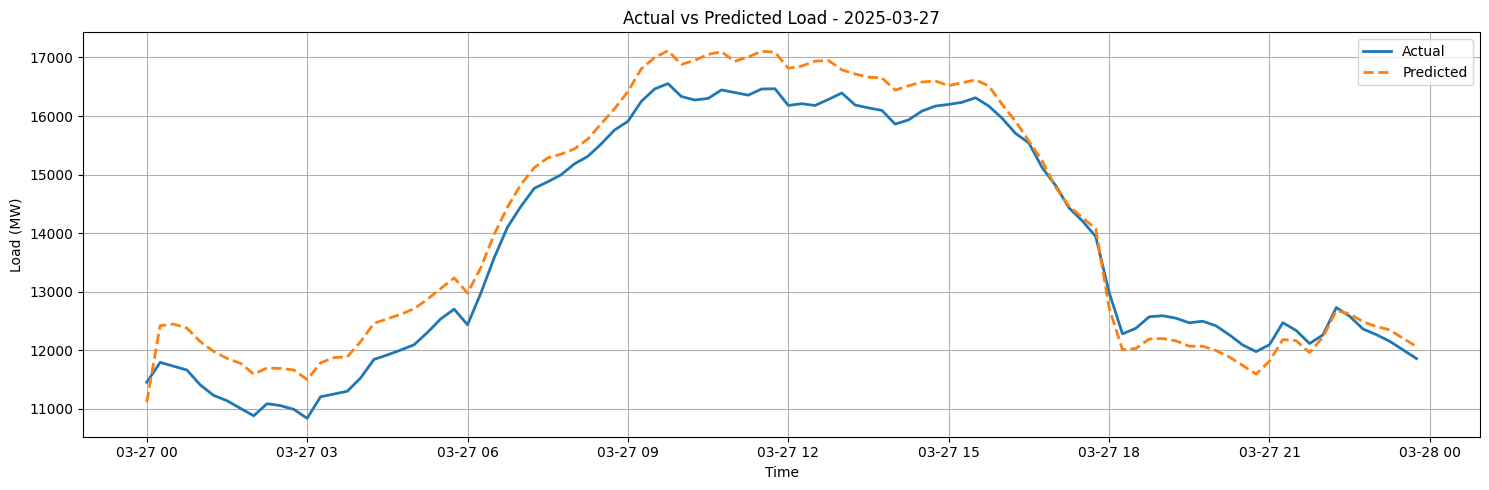

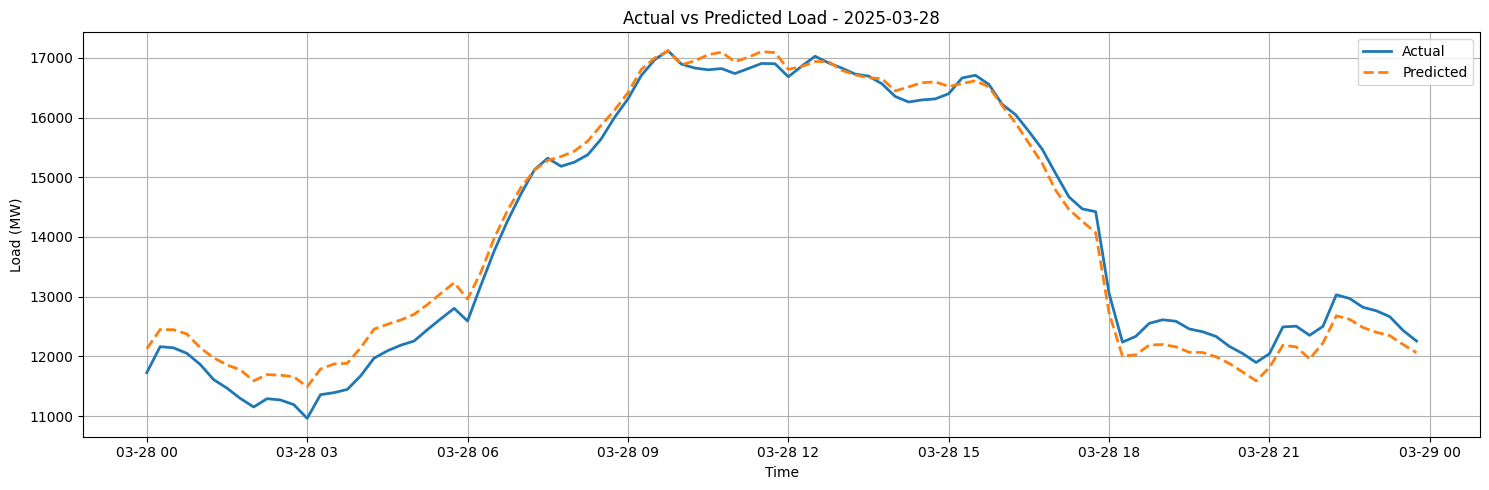

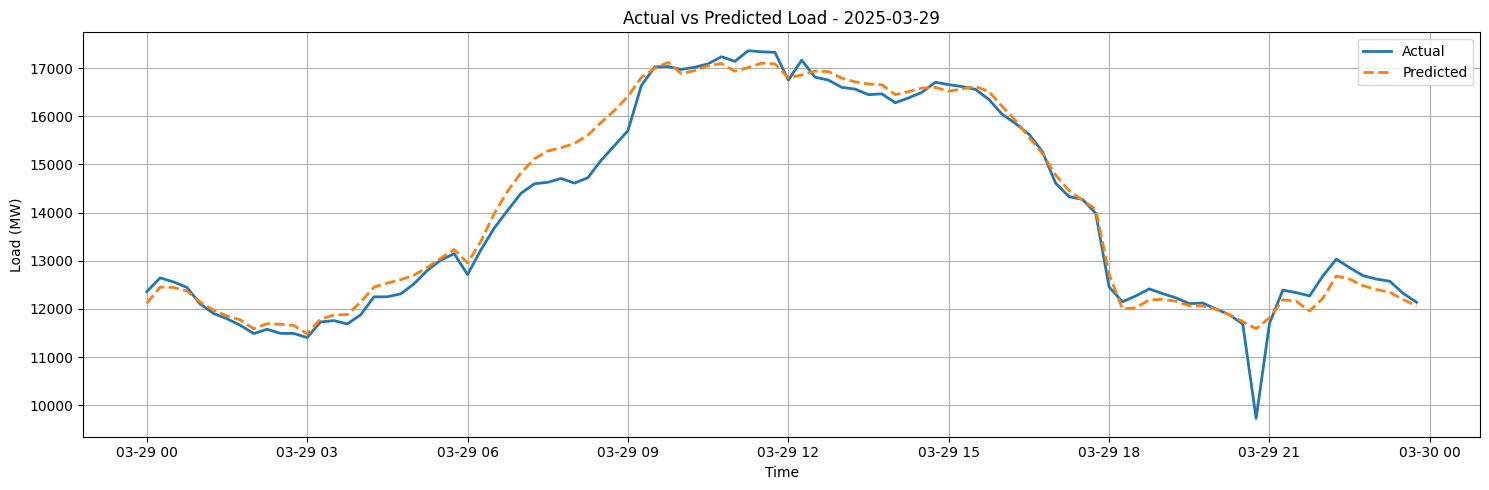

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dates to loop through
dates = [f"2025-03-{day:02d}" for day in range(25, 30)]

# Loop through each date
for date in dates:
    actual_path = f"/content/{date}.csv"
    predicted_path = f"/content/predictions/{date}_predicted.csv"

    # Load actual and predicted data
    actual_df = pd.read_csv(actual_path, parse_dates=['date_time'])
    predicted_df = pd.read_csv(predicted_path, parse_dates=['date_time'])

    # Extract load values
    actual = actual_df['load'].values
    predicted = predicted_df['load'].values

    # Plot actual vs predicted
    plt.figure(figsize=(15, 5))
    time_labels = pd.to_datetime(actual_df['date_time'])
    plt.plot(time_labels, actual, label='Actual', linewidth=2)
    plt.plot(time_labels, predicted, label='Predicted', linestyle='--', linewidth=2)
    plt.title(f"Actual vs Predicted Load - {date}")
    plt.xlabel("Time")
    plt.ylabel("Load (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


📊 Forecast Metrics:

Date                MAE       RMSE   MAPE (%)
----------------------------------------------
2025-03-25       226.75     305.01       1.60
2025-03-26       226.78     264.95       1.73
2025-03-27       438.92     484.21       3.28
2025-03-28       258.22     294.54       2.01
2025-03-29       220.14     332.75       1.63


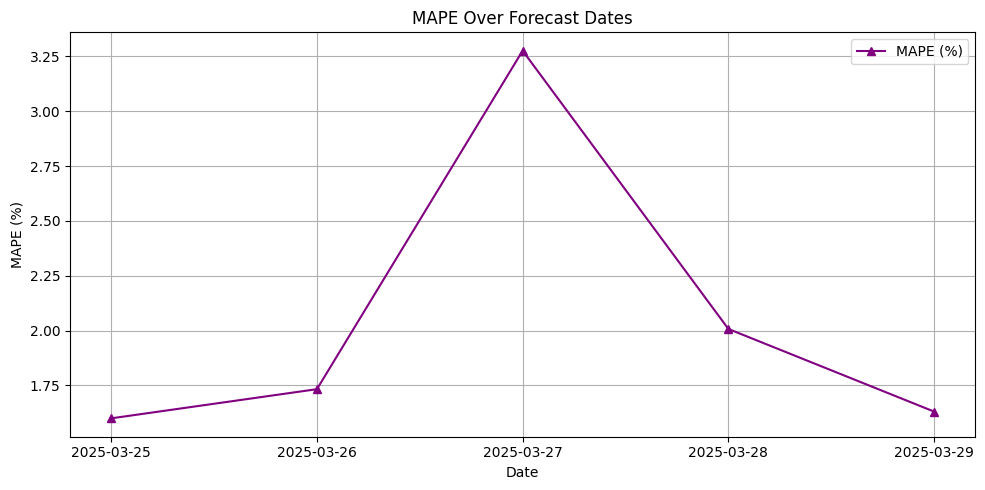

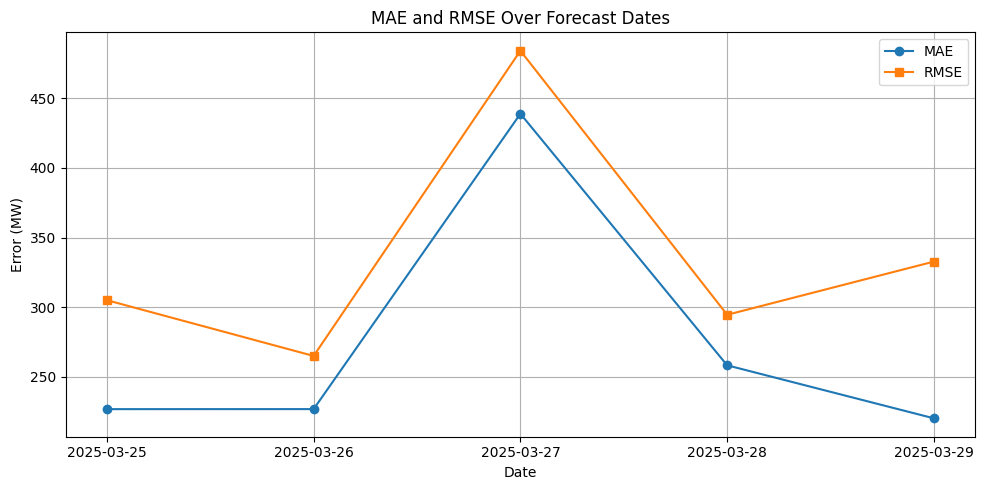

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Helper function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize lists for storing metrics
dates = [f"2025-03-{day:02d}" for day in range(25, 30)]
maes, rmses, mapes = [], [], []

# Calculate metrics for each date
print("📊 Forecast Metrics:\n")
print("{:<12} {:>10} {:>10} {:>10}".format("Date", "MAE", "RMSE", "MAPE (%)"))
print("-" * 46)

for date in dates:
    actual_path = f"/content/{date}.csv"
    predicted_path = f"/content/predictions/{date}_predicted.csv"

    actual_df = pd.read_csv(actual_path)
    predicted_df = pd.read_csv(predicted_path)

    actual = actual_df['load'].values
    predicted = predicted_df['load'].values

    # Metrics
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)

    maes.append(mae)
    rmses.append(rmse)
    mapes.append(mape)

    print(f"{date:<12} {mae:10.2f} {rmse:10.2f} {mape:10.2f}")

# Plot MAPE
plt.figure(figsize=(10, 5))
plt.plot(dates, mapes, marker='^', color='purple', label='MAPE (%)')
plt.title("MAPE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot MAE and RMSE
plt.figure(figsize=(10, 5))
plt.plot(dates, maes, marker='o', label='MAE')
plt.plot(dates, rmses, marker='s', label='RMSE')
plt.title("MAE and RMSE Over Forecast Dates")
plt.xlabel("Date")
plt.ylabel("Error (MW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
